# Protein Embedding #

In this project we will focus on `protein_embedding` by using one of the two methods:

* `GAE` - Graph Auto Encoder

*  `struc2vec`

Important references for that project : 

* *BioNEV GitHub site* - that github site contains lot of inforamtion that required for that project(such as code, explanations and running examples):

https://github.com/xiangyue9607/BioNEV/tree/master

* *Graph embedding on biomedical network* - an article about graph embedding and methods (such as `GAE` and `struc2vec`) : 

https://academic.oup.com/bioinformatics/article/36/4/1241/5581350?login=false

*  *STRING PPI* - site that contains the data we are going to work with in that project:

https://version-11-0.string-db.org/cgi/input.pl?sessionId=8aVJal1k2wit&input_page_show_search=on

## Import Libraries ##

The first step in the project is to import some libraries that important for the next steps leading 
to the final that, graph embedding.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib
import csv
import random
import warnings
import requests
import shutil
warnings.filterwarnings('ignore')

In [2]:
def PRINT_():
    print('#' *80)

## Downloading the data set from STRING PPI ##

Downloading the protein interaction data set versio `12.0` from *STRING PPI* as `.txt` file, and converting that into `.csv` 

In [3]:
# URL of the file to download
url = "https://stringdb-downloads.org/download/protein.links.v12.0/9606.protein.links.v12.0.txt.gz"

# Define the local file name
local_file_name = "9606.protein.links.v12.0.txt.gz"

# Send an HTTP GET request to the URL
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Open the local file in binary write mode
    with open(local_file_name, 'wb') as local_file:
        # Iterate through the response content and write it to the local file
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                local_file.write(chunk)
else:
    print("Failed to download the file. HTTP status code:", response.status_code)

# Close the response
response.close()

### View the data ###

After downloading the dataset from STRING PPI, the next step will be to extract the `.txt` file from it and convert
that file into `.csv` file

In [4]:
import pandas as pd

# Load the data from the .txt file
df = pd.read_csv('9606.protein.links.v12.0.txt', sep=' ')

# Convert it to a .csv file
df.to_csv('9606.protein.links.v12.0.csv', index=False)
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,173
1,9606.ENSP00000000233,9606.ENSP00000427567,154
2,9606.ENSP00000000233,9606.ENSP00000253413,151
3,9606.ENSP00000000233,9606.ENSP00000493357,471
4,9606.ENSP00000000233,9606.ENSP00000324127,201
...,...,...,...
13715399,9606.ENSP00000501317,9606.ENSP00000475489,195
13715400,9606.ENSP00000501317,9606.ENSP00000370447,158
13715401,9606.ENSP00000501317,9606.ENSP00000312272,226
13715402,9606.ENSP00000501317,9606.ENSP00000402092,169


In [5]:
len(df)

13715404

## Data Exploring ##

Upon downloading the dataset, the initial phase involves data examination and preparation for subsequent analytical procedures:

* Normalize the values of 'combined_score' to be in the range of 0-1

Normalize the 'combined_score' values to a 0-1 range, enhancing comparability and mitigating scale-related biases in data analysis or machine learning models. This involves adjusting each value by subtracting the minimum 'combined_score' and dividing by the range (difference between maximum and minimum values)

* Data Cleaning:

The primary task involves the refinement of the dataset by retaining only those protein pairs whose combined score exceeds the threshold of 0.7. This criterion is employed to ensure that only interactions with a significant degree of confidence are considered for further analysis.

* Deduplication:

The dataset is subjected to a process of deduplication, where redundant or repeated values are systematically removed. This step is imperative to maintain the integrity of the dataset and prevent biases that may arise from duplicate entries.

* Protein ID Replacement with Numeric Encoding:

In order to facilitate subsequent analytical procedures, the original protein identifiers are substituted with encoded numeric values. This transformation is undertaken to enhance computational efficiency and to enable the application of numerical methods in subsequent stages of analysis

The next step is createing a `.txt` file to see if there are duplicated pairs of `protein1` and `protein2` and `combined_score` in the dataset

In [6]:
output_file = 'proteins_check.txt'
input_file = '9606.protein.links.v12.0.csv'
# Open the input CSV file and the output text file
with open(input_file, 'r') as csv_file, open(output_file, 'w') as txt_file:
    csv_reader = csv.DictReader(csv_file)
    
    # Write the header to the output text file
    txt_file.write(f"'protein1' 'protein2' 'combined_score\n")
    
    # Iterate through the rows in the CSV and write them to the text file
    for row in csv_reader:
        txt_file.write(f"{row['protein1']} {row['protein2']} {row['combined_score']}\n")

PRINT_()
print("Conversion complete. The text file has been created.")
PRINT_()

################################################################################
Conversion complete. The text file has been created.
################################################################################


### Normalize the values of 'combined_score' to be in the range of 0-1 ###

In [7]:
# View the min& max values of the column 'combined_score':

max_value = df['combined_score'].max()
min_value = df['combined_score'].min()

PRINT_()
print(f"The maximum value of the column 'combined_score' is -> {max_value}, or {max_value/10}%")
print(f"The minimum value of the column 'combined_score is -> {min_value} or {min_value/10}%")
PRINT_()

################################################################################
The maximum value of the column 'combined_score' is -> 999, or 99.9%
The minimum value of the column 'combined_score is -> 150 or 15.0%
################################################################################


In [8]:
# Normalize the 'combined_score' column to the range 0-1
# Extract the 'combined_score' column
combined_score = df['combined_score']

df['combined_score'] = (combined_score - min_value) / (max_value - min_value)

print(len(df))

13715404


In [9]:
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000356607,0.027091
1,9606.ENSP00000000233,9606.ENSP00000427567,0.004711
2,9606.ENSP00000000233,9606.ENSP00000253413,0.001178
3,9606.ENSP00000000233,9606.ENSP00000493357,0.378092
4,9606.ENSP00000000233,9606.ENSP00000324127,0.060071
...,...,...,...
13715399,9606.ENSP00000501317,9606.ENSP00000475489,0.053004
13715400,9606.ENSP00000501317,9606.ENSP00000370447,0.009423
13715401,9606.ENSP00000501317,9606.ENSP00000312272,0.089517
13715402,9606.ENSP00000501317,9606.ENSP00000402092,0.022379


In [10]:
# Create a set of unique proteins by combining both columns
unique_proteins = set(df['protein1']).union(df['protein2'])

# Count the unique proteins
unique_protein_count = len(unique_proteins)

PRINT_() 
print(f"The number of unique proteins in the data set of version 12.0 is -> {unique_protein_count}")
print(f"The number of unique proteins if the data set of version 10.5 is -> 15131")
print(f"There are {unique_protein_count - 15131} new unique proteins in the 11.0 version of STRING PPI")
PRINT_() 

################################################################################
The number of unique proteins in the data set of version 12.0 is -> 19622
The number of unique proteins if the data set of version 10.5 is -> 15131
There are 4491 new unique proteins in the 11.0 version of STRING PPI
################################################################################


In [11]:
PRINT_() 
print(f"Nex maximum of the column 'combined_score' is -> {df['combined_score'].max()}")
print(f"New minimum of the column 'combied_score' is -> {df['combined_score'].min()}")
PRINT_()

################################################################################
Nex maximum of the column 'combined_score' is -> 1.0
New minimum of the column 'combied_score' is -> 0.0
################################################################################


### Drop all the values that their 'combined_score' is under 0.7 ###

Before we move on, we will want to work only with sets of proteins that their
`combined_socore` in the range of `0.7-1.0`. 
Therefore, we will need to drop all the values that their `combined_score < 0.7`

In [12]:
number_of_rows_before_dropping = len(df)
# Drop rows where 'combined_score' is less than 0.7
df = df[df['combined_score'] >= 0.7]

# Reset the index if you want to keep it continuous
df.reset_index(drop=True, inplace=True)

unique_proteins_after_dropping = len(set(df['protein1']).union(df['protein2']))

In [15]:
PRINT_() 
print(f"The number of rows before dropping the rows with `combined_score` < 0.7 -> [{number_of_rows_before_dropping}]")
print(f"The number of rows after dropping the rows with 'combined_score` < 0.7 are -> [{len(df)}]")
print(f"Got rid of -> [{number_of_rows_before_dropping - len(df)}] values in total, that is {((((number_of_rows_before_dropping - len(df))/number_of_rows_before_dropping))*100):.2f}% of the total data")
PRINT_() 
print(f"The number of unique proteins before dropping is -> {len(unique_proteins)}")
print(f"The number of unique proteins after dropping is -> {unique_proteins_after_dropping}")
print(f"Dropped {len(unique_proteins) - unique_proteins_after_dropping} unique proteins")
PRINT_() 

################################################################################
The number of rows before dropping the rows with `combined_score` < 0.7 -> [13715404]
The number of rows after dropping the rows with 'combined_score` < 0.7 are -> [398296]
Got rid of -> [13317108] values in total, that is 97.10% of the total data
################################################################################
The number of unique proteins before dropping is -> 19622
The number of unique proteins after dropping is -> 15514
Dropped 4108 unique proteins
################################################################################


In [16]:
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000158762,0.795053
1,9606.ENSP00000000233,9606.ENSP00000262305,0.944641
2,9606.ENSP00000000233,9606.ENSP00000329419,0.709069
3,9606.ENSP00000000233,9606.ENSP00000469035,0.759717
4,9606.ENSP00000000233,9606.ENSP00000256682,0.713781
...,...,...,...
398291,9606.ENSP00000501277,9606.ENSP00000326630,0.932862
398292,9606.ENSP00000501277,9606.ENSP00000263726,0.935218
398293,9606.ENSP00000501317,9606.ENSP00000290524,0.742049
398294,9606.ENSP00000501317,9606.ENSP00000305071,0.975265


### Remove duplicated rows from the data ###

The next step is remove duplicated rows in our data set.
The idea is if `protein1` and `protein2` appear in our data which means that there are edge between them, and *also* there is a row with the same values of `protein1` and `protein2` but in different order, remove that duplicated row to reduce data.

In [17]:
num_of_rows_before_drop = len(df)

# Create a new DataFrame with sorted tuples of 'protein1' and 'protein2'
df['sorted_nodes'] = df.apply(lambda row: tuple(sorted([row['protein1'], row['protein2']])), axis=1)

# Use .loc to drop duplicates while preserving the first occurrence
df = df.loc[df.duplicated(subset=['sorted_nodes'], keep='first')]

# Drop the 'sorted_nodes' column if you no longer need it
df = df.drop(columns='sorted_nodes')

# Reset the index to maintain the order
df.reset_index(drop=True, inplace=True)

# Save the cleaned DataFrame back to a CSV file
#df.to_csv('cleaned_file.csv', index=False)

num_of_rows_after_drop = len(df)
unique_proteins_after_dropping = len(set(df['protein1']).union(df['protein2']))

PRINT_() 
print(f"Number of rows before removing duplicated values -> {num_of_rows_before_drop}")
print(f"Number of rows after removing duplicated values -> {num_of_rows_after_drop}")
print(f"Total number of duplicated values -> {num_of_rows_before_drop - num_of_rows_after_drop}")
PRINT_() 
print(f"The number of unique proteins after dropping is -> {unique_proteins_after_dropping}")
PRINT_() 

################################################################################
Number of rows before removing duplicated values -> 398296
Number of rows after removing duplicated values -> 199148
Total number of duplicated values -> 199148
################################################################################
The number of unique proteins after dropping is -> 15514
################################################################################


## Building a graph with NetworkX ##

The next step is beuild a graph data structure s.t. edge exsist between `protein1` and `protein2` that in the same row
in `df` with `combined_score` as attribute on the edge between them.

For that, we need to install `networkx` library.

In [20]:
G_ = nx.Graph()

# Iterate through the DataFrame and add edges with 'combined_score' as edge attribute
for index, row in df.iterrows():
    protein1 = row['protein1']
    protein2 = row['protein2']
    combined_score = row['combined_score']
    G_.add_edge(protein1, protein2, combined_score=combined_score)

In [21]:
PRINT_()
print(f"Number of nodes in G_ -> {G_.number_of_nodes()}")
print(f"Number of edges in G_ -> {G_.number_of_edges()}")
PRINT_()

################################################################################
Number of nodes in G_ -> 15514
Number of edges in G_ -> 199148
################################################################################


### Creating text file that mapps index to unique protein ###

Before moving forward, we need to create `.txt` file that mapps unique `index`
for each unique `protein`. 
The reason behind that step -> prepare for creating `.edgelist` file for the graph embedding input.

In [22]:
# Helper function to make .txt that contains of 'index protein_id' rows
def write_graph_to_txt(graph, filename):
    with open(filename, 'w') as file:
        for index, node in enumerate(graph.nodes):
            file.write(f"{index} {node}\n")

In [23]:
output_file_ = "indx_to_protein.txt"

write_graph_to_txt(G_, output_file_)

*Visualize subsampled graph of the original graph in order in reduce run time.*

In [24]:
# Assuming you have your original graph 'G'
nodes = list(G_.nodes())
subsampled_nodes = random.sample(nodes, int(len(G_) * 0.05)) 
subsampled_graph = G_.subgraph(subsampled_nodes)

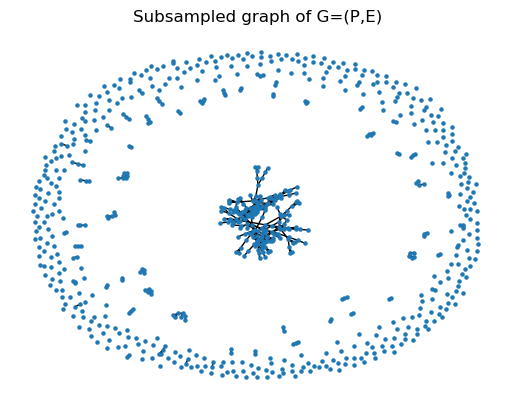

In [25]:
import matplotlib.pyplot as plt

# Assuming you have your subsampled graph 'subsampled_graph'
layout = nx.spring_layout(subsampled_graph)

# Draw the nodes
nx.draw_networkx_nodes(subsampled_graph, layout, node_size=5)

# Draw the edges (if needed)
nx.draw_networkx_edges(subsampled_graph, layout)

# Show the graph
plt.title("Subsampled graph of G=(P,E)") # 'P' stands for proteins, 'E' stand for edges
plt.axis('off')
plt.show()

As we can see in the graph above, there are some nodes (i.e. proteins) which are not connected to any other node. 
One of the reasons for that can be our divided data in graph G, that graph does not contain all of the edges in
our data set. Therefore, there can be some edges that does not exist in graph G.
Another reason can be the cause of our `subsampled` graph of G that we generated for faster graph plotting time.

## Write the graph G=(P,E) as `edgelist` ##

The next step is to convert (i.e. write) the graph `G=(P,E)` to
name `edgelist`, that is simply going to convert the graph into `.txt`
file with the next format:

`protein1` `protein2` 

`protein3` `protein4`

`protein5` `protein6`
        .
        .
        .

*Note* - we dont want to include the `combined_score` data in our `proteint_edgelist.txt`. Therefore, turn `data=Flase`

In [26]:
p_edgelist_ = nx.write_edgelist(G_, "STRING_PPI_12_0.edgelist", data=False)

In [27]:
# Load the node index mapping from "node_list.txt"
index_to_protein = {}
with open("indx_to_protein.txt", 'r') as node_list_file:
    for line in node_list_file:
        parts = line.strip().split(' ')
        if len(parts) == 2:
            index, protein = parts
            index_to_protein[protein] = index

# Create a new file to write the updated edge list for the data:
with open("STRING_PPI_12_0_.edgelist", 'w') as updated_file:
    with open("STRING_PPI_12_0.edgelist", 'r') as proteins_file:
        for line in proteins_file:
            source_protein, target_protein = line.strip().split(' ')
            source_index = index_to_protein.get(source_protein)
            target_index = index_to_protein.get(target_protein)
            if source_index is not None and target_index is not None:
                updated_file.write(f"{source_index} {target_index}\n")

## Graph Embedding ##

The next steps, will include downloading BioNEV repository from GitHub and making graph embeddings using
our proteins edgelist data structure we created above.

### Downloading BioNEV repository ###

The BioNEV repository is taken from GitHun linked:

https://github.com/xiangyue9607/BioNEV/tree/master

In [24]:
!git clone https://github.com/xiangyue9607/BioNEV.git

fatal: destination path 'BioNEV' already exists and is not an empty directory.


Next, move the STRING PPI edgelist to the `data` dir that located in `BioNEV` repository in order
to execute the graph embedding later on.

In [28]:
import shutil

source_file = "STRING_PPI_12_0_.edgelist"
destination_directory = "C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research/BioNEV/data"

shutil.copy(source_file, destination_directory)

'C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research/BioNEV/data\\STRING_PPI_12_0_.edgelist'

In [26]:
cd BioNEV

C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research\BioNEV


The next step will be downloading the BioNEV repository and then downloading the `code` from it.

In [27]:
pip install -e.

Obtaining file:///C:/Users/gavvi/Desktop/Programming/Python/DeepLearning%20Research/BioNEV
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: bionev
    Found existing installation: bionev 0.1.0.dev0
    Uninstalling bionev-0.1.0.dev0:
      Successfully uninstalled bionev-0.1.0.dev0
  Running setup.py develop for bionev
Note: you may need to restart the kernel to use updated packages.


### Graph Embedding using GAE ### 

Finally, we can generate the embedding for our PPI data set.

#### Extracting the proteins embeddings after executing GAE method #### 

Due to the intricacy of the methodology employed, we opted to utilize the Google Colab environment with a T4 Graphics Processing Unit (GPU) to execute struc2vec. This decision was motivated by the desire to achieve expedited runtime during the generation of protein embeddings.

*The model's performance was as follows:*

In [ ]:
!bionev --input ./data/STRING_PPI_12_0_.edgelist \
       --output ./embeddings/STRING_PPI_12_0_GAE_embeddings.txt \
       --dimensions 500 \
       --method GAE \
       --epochs 800 \
       --task link-prediction \
       --eval-result-file eval_result.txt

######################################################################<br>
Embedding Method: GAE, Evaluation Task: link-prediction<br>
######################################################################<br>
Original Graph: nodes: 15514 edges: 199148<br>
Training Graph: nodes: 15514 edges: 159675<br>
Loading training graph for learning embedding...<br>
Graph Loaded...<br>
Epoch: 0001 train_loss= 0.70996 train_acc= 0.00140 time= 20.58250<br>
Epoch: 0101 train_loss= 0.51424 train_acc= 0.32072 time= 11.96413<br>
Epoch: 0201 train_loss= 0.41721 train_acc= 0.55213 time= 12.42823<br>
Epoch: 0301 train_loss= 0.39731 train_acc= 0.56256 time= 12.88931<br>
Epoch: 0401 train_loss= 0.38923 train_acc= 0.55992 time= 6.75705<br>
Epoch: 0501 train_loss= 0.38498 train_acc= 0.55583 time= 7.55488<br>
Epoch: 0601 train_loss= 0.38354 train_acc= 0.55344 time= 6.53523<br>
Epoch: 0701 train_loss= 0.38255 train_acc= 0.54968 time= 7.42164<br>
Optimization Finished!<br>
(15514, 500)<br>
Embedding Learning Time: `8072.91 s`<br>
Nodes with embedding: 15514<br>
Begin evaluation...<br>
######### Link Prediction Performance #########<br>
`AUC-ROC: 0.814, AUC-PR: 0.821, Accuracy: 0.745, F1:0.738`<br>
##################################################<br>
Prediction Task Time: `1647.06 s`

#### Restore the genuine identifiers of proteins to the embedding text file ####

The subsequent phase involves accessing the `.txt` file containing protein embeddings generated through the `GAE` method on the `GPU`. Subsequently, it necessitates the conversion of all numeric identifiers of the proteins to their original identifiers, as they were present in the initial *STRING* dataset.

For example: for the protein with the id number `7539` will turn into -> `9606.ENSP00000350012`


In [45]:
cd embeddings

C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research\BioNEV\embeddings


In [46]:
import shutil

source_file = "STRING_PPI_12_0_GAE_embeddings.txt"
destination_directory = "C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research"

shutil.copy(source_file, destination_directory)

'C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research\\STRING_PPI_12_0_GAE_embeddings.txt'

In [47]:
import os

os.chdir(destination_directory)
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research


In [48]:
def replace_mapped_ids(embeddings_file, node_list_file):
    """
    The function takes the embedding file and return the proteins integer id to their original
    id as originated from STRING PPI dataset
    """
    
    # Create a dictionary to map mapped IDs to real protein IDs
    id_mapping = {}

    with open(node_list_file, 'r') as node_list:
        for line in node_list:
            mapped_id, real_id = line.strip().split()
            id_mapping[mapped_id] = real_id

    # Read the embeddings file, replace mapped IDs with real IDs, and write to a new file
    with open(embeddings_file, 'r') as embeddings:
        lines = embeddings.readlines()

    with open(embeddings_file, 'w') as embeddings:
        for line in lines:
            if not line.strip():  # Skip empty lines
                continue
            tokens = line.strip().split()
            mapped_id = tokens[0]
            if mapped_id in id_mapping:
                real_id = id_mapping[mapped_id]
                tokens[0] = real_id
                new_line = ' '.join(tokens)
                embeddings.write(new_line + '\n')
            else:
                embeddings.write(line)

In [49]:
embeddings_file = "STRING_PPI_12_0_GAE_embeddings.txt"
node_list_file = "indx_to_protein.txt"
replace_mapped_ids(embeddings_file, node_list_file)

The next step is to convert the `.txt` file into `.csv` file, so we can visualize our embedding `.txt` file in more
informative way with the format:

`protein1_id` _ `protein1_embedding_vector`

`protein2_id` _ `protein2_embedding_vector`

`protein3_id` _ `protein3_embedding_vector`

....

#### Generate a CSV file to enhance the visualization of the embedding data ####

In [50]:
import csv

def create_csv_from_embeddings(embeddings_file, csv_output_file):
    """
    The function takes '.txt' file of proteins and their corresponding 
    embeddings vectors, and turns that into '.csv' file
    """
    data = []
    
    # Read the modified embeddings file and extract the data
    with open(embeddings_file, 'r') as embeddings:
        for line in embeddings:
            line = line.strip()
            if line:
                values = line.split()
                data.append(values)

    # Write the data to a CSV file
    with open(csv_output_file, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        # Write the header (column names)
        header = ["Protein"] + [f"Embedding_{i}" for i in range(1, len(data[0]))]
        csvwriter.writerow(header)

        # Write the data rows
        for values in data:
            protein_id, embeddings = values[0], values[1:]
            csvwriter.writerow([protein_id] + embeddings)

In [51]:
embeddings_file = "STRING_PPI_12_0_GAE_embeddings.txt"
csv_output_file = "output_embeddings_GAE.csv"
create_csv_from_embeddings(embeddings_file, csv_output_file)

#### Creating a text file to examine zero vectors #### 

We observed a prevalence of zero vector embeddings for certain proteins. Various factors may contribute to this phenomenon, with one potential explanation being the utilization of outdated code sourced from the BioNEV repository for the generation of protein vector embeddings. The necessity to adapt numerous sections of the code to align with our dataset and the updated versions of libraries, no longer readily available for installation, constituted a crucial step in addressing this issue.

In preparation for the subsequent application of the struc2vec method to generate protein vector embeddings, we will compile a text file encompassing the identifiers of all such proteins. Additionally, this file will provide an enumeration of the quantity of proteins exhibiting zero vector embeddings.

In [52]:
import pandas as pd

def write_zero_vector_proteins(csv_file_path, output_file_path):
    # Load the CSV file into a DataFrame, skipping the first two rows
    df = pd.read_csv(csv_file_path, skiprows=2)

    # Identify rows where all columns have values equal to 0
    zero_rows = df[df.iloc[:, 1:].eq(0).all(axis=1)]

    # Extract all protein IDs from the rows with all-zero vector embeddings
    zero_protein_ids = zero_rows.iloc[:, 0].unique()

    # Count the number of rows with all zeros
    num_zero_rows = len(zero_rows)

    print(f"Number of rows with all zero vector embeddings: {num_zero_rows}")

    # Write the count information to the first row of the output file
    with open(output_file_path, 'w') as file:
        file.write(f"Number of rows with all zero vector embeddings: {num_zero_rows}\n")

        # Write all unique protein IDs to the file
        for protein_id in zero_protein_ids:
            file.write(f"{protein_id}\n")

    print(f"All unique protein IDs with all zero vector embeddings written to {output_file_path}")

In [53]:
write_zero_vector_proteins("output_embeddings_GAE.csv" , "zero_vector_proteins_GAE.txt")

Number of rows with all zero vector embeddings: 446
All unique protein IDs with all zero vector embeddings written to zero_vector_proteins_GAE.txt


### Graph Embedding using Struc2vev ###

After generating graph embeddingd for STRING PPI version 12.0 with GAE method, we will try also generating graph embeddings with `struc2vec` method.
The reason is due to the most accurate results of those two methods that shown in the article :

https://academic.oup.com/bioinformatics/article/36/4/1241/5581350?login=false

In [54]:
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research


#### Extracting the proteins embeddings after executing struc2vec method #### 

Due to the intricacy of the methodology employed, we opted to utilize the Google Colab environment with a T4 Graphics Processing Unit (GPU) to execute struc2vec. This decision was motivated by the desire to achieve expedited runtime during the generation of protein embeddings.

In [ ]:
!bionev --input ./data/STRING_PPI_12_0_.edgelist \
     --output ./embeddings/STRING_PPI_12_0_s2vec_embeddings.txt \
     --dimensions 500 \
     --method struc2vec \
     --task link-prediction 

*The model's performance was as follows:*

######################################################################<br>
Embedding Method: struc2vec, Evaluation Task: link-prediction<br>
######################################################################<br>
Original Graph: nodes: 15514 edges: 199148<br>
Training Graph: nodes: 15514 edges: 159675<br>
Loading training graph for learning embedding...<br>
Graph Loaded...<br>
create distances network..<br>
begin random walk...<br>
walk finished..<br>
Learning embeddings...<br>
Embedding Learning Time: `5034.82 s`<br>
Nodes with embedding: 15514<br>
Begin evaluation...<br>
######### Link Prediction Performance #########<br>
`AUC-ROC: 0.877, AUC-PR: 0.883, Accuracy: 0.799, F1: 0.800`<br>
##################################################<br>
Prediction Task Time: `516.84 s`<br>

#### Restore the genuine identifiers of proteins to the embedding text file ####

The subsequent phase involves accessing the `.txt` file containing protein embeddings generated through the `struc2vec` method on the `GPU`. Subsequently, it necessitates the conversion of all numeric identifiers of the proteins to their original identifiers, as they were present in the initial *STRING* dataset.

For example: for the protein with the id number `7539` will turn into -> `9606.ENSP00000350012`

In [55]:
cd "BioNEV/embeddings"

C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research\BioNEV\embeddings


In [56]:
import shutil

source_file = "STRING_PPI_12_0_s2vec_embeddings.txt"
destination_directory = "C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research"

shutil.copy(source_file, destination_directory)

'C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research\\STRING_PPI_12_0_s2vec_embeddings.txt'

In [57]:
import os

os.chdir(destination_directory)
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research


The function utilized for the conversion of protein identifiers subsequent to the implementation of the Graph Autoencoder (GAE) method can be employed once again for the purpose of reverting protein identifiers to their initial form.

In [58]:
embeddings_file = source_file
node_list_file = "indx_to_protein.txt"
replace_mapped_ids(embeddings_file, node_list_file)

The next step is to convert the `.txt` file into `.csv` file, so we can visualize our embedding `.txt` file in more
informative way with the format:

`protein1_id` _ `protein1_embedding_vector`

`protein2_id` _ `protein2_embedding_vector`

`protein3_id` _ `protein3_embedding_vector`

....

#### Generate a CSV file to enhance the visualization of the embedding data ####

In [59]:
csv_output_file = "output_embeddings_st2vec.csv"
create_csv_from_embeddings(embeddings_file, csv_output_file)

#### Creating a text file to examine zero vectors ####

In [60]:
write_zero_vector_proteins("output_embeddings_st2vec.csv" , "zero_vector_proteins_st2vec.txt")

Number of rows with all zero vector embeddings: 0
All unique protein IDs with all zero vector embeddings written to zero_vector_proteins_st2vec.txt
